# PCBO: Preferential Causal Bayesian Optimisation


In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Custom modules
from flows import real_nvp, create_base_distribution
from prefflow import PrefFlow
from pcbo_dataset import PCBO_Dataset_Six
from parent_posterior import ParentPosterior, LocalParentPosterior
from acquisition import pig_pairwise, eeig_pairwise
from dag_visual import plot_dag

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device and precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision_double = True
print(f"Using device: {device}")

Using device: cpu


## Problem Setup

In [55]:
"""
Toy Problem: X1 -> Y <- X2
- We can intervene on X1, X2, or Y
- True utility: minimize |Y| with small intervention cost
- Learn both the causal graph and utility function from preferences
"""

# Problem parameters
n_nodes = 6		# Number of nodes in the causal graph
d_utility = 2  # Dimensionality for utility function input
n_initial_prefs = 20  # Initial preference data
n_iterations = 50  # PCBO iterations
k = 2  # k-wise preferences (pairwise for now)
flow_layers = 5  # Number of flow layers in the PrefFlow

# Create synthetic dataset
dataset = PCBO_Dataset_Six(
    n_queries=n_initial_prefs,
    noise_std=0.1,
    domain=(-2, 2),
    seed=42
)

true_adj, node_names = dataset.get_causal_graph()
print(f"True causal graph:\n{true_adj}")
print(f"Node names: {node_names}")

True causal graph:
tensor([[0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]])
Node names: ['X1', 'X2', 'X3', 'X4', 'X5', 'Y']


## Helper Classes and Functions

In [ ]:
class PreferenceDataset:
    """Efficient storage for preference comparisons"""
    def __init__(self, device):
        self.device = device
        self.feature_pairs = []  # List of (feat_winner, feat_loser) tuples
        self.labels = []  # List of labels (always 1.0 for winner first)
        self._X_cache = None
        self._Y_cache = None
        self._cache_valid = False
        
    def add_preference(self, outcome_winner, outcome_loser):
        """Add a new preference comparison"""
        feat_winner = intervention_to_utility_features(outcome_winner)
        feat_loser = intervention_to_utility_features(outcome_loser)
        self.feature_pairs.append((feat_winner, feat_loser))
        self.labels.append(1.0)
        self._cache_valid = False
        
    def add_from_query(self, query_data):
        """Add preferences from a query with k options"""
        outcomes = query_data['outcomes']
        winner_idx = query_data['winner_idx']
        
        # Compare winner against all losers
        for i in range(len(outcomes)):
            if i != winner_idx:
                self.add_preference(outcomes[winner_idx], outcomes[i])
        
    def get_batch(self, last_n=None):
        """Get preference data in PrefFlow format"""
        if len(self.feature_pairs) == 0:
            return None, None
            
        pairs = self.feature_pairs[-last_n:] if last_n else self.feature_pairs
        labels = self.labels[-last_n:] if last_n else self.labels
        
        n_comparisons = len(pairs)
        feat_dim = pairs[0][0].shape[0]
        X = torch.zeros(2, feat_dim, n_comparisons).to(self.device)
        
        for i, (feat1, feat2) in enumerate(pairs):
            X[0, :, i] = feat1.to(self.device)
            X[1, :, i] = feat2.to(self.device)
        
        Y = torch.tensor(labels, dtype=torch.float32).to(self.device)
        
        return X, Y
    
    def __len__(self):
        return len(self.feature_pairs)

def intervention_to_utility_features(intervention_outcome):
    """
    Map intervention outcomes to features for utility function
    Normalized to prevent numerical issues
    """
    if not isinstance(intervention_outcome, torch.Tensor):
        intervention_outcome = torch.tensor(intervention_outcome, dtype=torch.float32)
    
    # Normalize Y value to [-1, 1] range
    if n_nodes == 6:
        y_value = intervention_outcome[5]  # Y is at index 5
    else:
        y_value = intervention_outcome[2]  # For 3-node case
    y_normalized = torch.tanh(y_value / 2.0)  # Assuming Y is roughly in [-2, 2]

    # Fixed intervention cost (also normalized)
    intervention_cost = 0.1
    
    features = torch.tensor([
        y_normalized.item() if isinstance(y_normalized, torch.Tensor) else y_normalized,
        intervention_cost
    ], dtype=torch.float32)
    
    return features

# Map a full outcome vector to (x_for_graph, y) for the ParentPosterior
def outcome_to_xy_local(outcome, lpp):
    x = outcome[lpp.parent_idx].unsqueeze(0)
    y = outcome[lpp.target_idx].reshape(1, 1)
    return x, y

# Helper to create locals for all targets except Y=5
def make_all_local_posts(n_nodes, y_idx=5):
    locals_dict = {}
    for t in range(n_nodes):
        if t == y_idx:
            parent_idx = [i for i in range(n_nodes) if i != y_idx]
            pi = 0.30
        else:
            parent_idx = [i for i in range(n_nodes) if i != t and i != y_idx]
            pi = 0.10
        locals_dict[t] = LocalParentPosterior(
            parent_idx=parent_idx, target_idx=t,
            a0=1.0, b0=1.0, tau2=1.0,
            prior_sparsity=pi, device=device, dtype=torch.float64
        )
    return locals_dict

## PCBO Main Class

In [ ]:
class PCBO:
    def __init__(self, dataset, device, n_iterations=50):
        self.dataset = dataset
        self.device = device
        self.n_iterations = n_iterations
        
        # Initialise components
        self.pref_flow = self._create_flow()
        
        # Keep track of all local parent posteriors
        self.local_posts = make_all_local_posts(self.dataset.n_nodes, y_idx=5)
        self.parent_posterior = self.local_posts[5]  # keep a convenience handle for Y

        # Get true adjacency matrix
        self.true_adj, self.node_names = dataset.get_causal_graph()
        
        # Efficient preference storage
        self.pref_dataset = PreferenceDataset(device)
        
        # Storage for tracking progress
        self.iteration_history = []
        self.graph_distances = []
        self.utility_errors = []
        self.edge_prob_errors = []
        self.selected_interventions = []
        self.causal_buffer = []  # Buffer for causal updates
        
        # Stability tracking
        self.flow_stable = True
        self.instability_count = 0
        self.reinitialization_count = 0
        
    def _create_flow(self):
        """Create a fresh PrefFlow model"""
        base_dist = create_base_distribution(d_utility, self.device, precision_double)
        nf_model = real_nvp(flow_layers, d_utility, base_dist, self.device, precision_double)

        s_init = 1.0
        pref_flow = PrefFlow(nf_model, s_init, d_utility, ranking=False, 
                            device=self.device, precision_double=precision_double)
        return pref_flow
        
    def train_utility_on_preferences(self, n_epochs=50, lr=1e-4, batch_size=None):
        """
        Update PrefFlow based on preference data with improved stability
        """
        # Use all available data if batch_size not specified
        if batch_size is None:
            batch_size = min(40, len(self.pref_dataset))
        
        # Get data from preference dataset
        X, Y = self.pref_dataset.get_batch(last_n=batch_size)
        
        if X is None or Y is None:
            print("    No preference data available")
            return []
        

        base_lr = 1e-4
        param_groups = [
            {"params": [p for n,p in self.pref_flow.named_parameters() if n != "s_raw"],
             "lr": base_lr, "weight_decay": 1e-6},
            {"params": [self.pref_flow.s_raw],
             "lr": base_lr * 5, "weight_decay": 0.0},
        ]
        optimizer = torch.optim.Adam(param_groups)
        losses = []
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            
            try:
                # Compute loss
                log_posterior = self.pref_flow.logposterior((X, Y))
                
                # Check for NaN
                if torch.isnan(log_posterior) or torch.isinf(log_posterior):
                    self.flow_stable = False
                    self.instability_count += 1
                    
                    if self.instability_count > 5:
                        print(f"    Flow unstable, reinitializing...")
                        self._reinitialize_flow()
                        return self.train_utility_on_preferences(n_epochs//2, lr*0.5, batch_size)
                    continue
                
                loss = -log_posterior
                
                # Only backprop if loss is valid and reasonable
                if not torch.isnan(loss) and not torch.isinf(loss) and abs(loss.item()) < 1e6:
                    loss.backward()
                    
                    # Gradient clipping for stability
                    torch.nn.utils.clip_grad_norm_(self.pref_flow.parameters(), max_norm=1.0)
                    
                    optimizer.step()
                    losses.append(loss.item())
                    
                    # Reset instability count on successful training
                    self.flow_stable = True
                    self.instability_count = 0
                    
                    if epoch % 20 == 0:
                        print(f"    Epoch {epoch}, Loss: {loss.item():.4f}")
                        
            except Exception as e:
                print(f"    Error during training: {e}")
                self.instability_count += 1
                if self.instability_count > 5:
                    self._reinitialize_flow()
                    return losses
                    
        return losses
    
    def _reinitialize_flow(self):
        """Reinitialize the flow if it becomes unstable"""
        print("    Creating new flow due to instability...")
        self.pref_flow = self._create_flow()
        self.flow_stable = True
        self.reinitialization_count += 1
    
    def select_next_intervention(self, current_iteration=0, n_candidates=30):
        """
        Select next intervention using PCBO acquisition functions
        """
        # Generate candidate interventions
        candidate_interventions = []
        candidate_features = []
        candidate_outcomes = []

        # Ensure coverage of all nodes
        for node_idx in range(self.dataset.n_nodes):
            n_per_node = n_candidates // self.dataset.n_nodes
            for _ in range(n_per_node):
                value = np.random.uniform(-2, 2)
                intervention = (node_idx, value)
                candidate_interventions.append(intervention)
                
                # Execute intervention to get outcome
                outcome = self.dataset._compute_intervention_outcome(node_idx, value)
                candidate_outcomes.append(outcome)

                # Convert to utility features
                features = intervention_to_utility_features(outcome)
                candidate_features.append(features)

        # Targeted exploration for early iterations
        if current_iteration < 10:
            target_node = current_iteration % 2  # Alternate between X1 and X2
            for _ in range(5):  # Add a few extra candidates for target_node
                value = np.random.uniform(-2, 2)
                intervention = (target_node, value)
                candidate_interventions.append(intervention)
                outcome = self.dataset._compute_intervention_outcome(target_node, value)
                candidate_outcomes.append(outcome)
                features = intervention_to_utility_features(outcome)
                candidate_features.append(features)
        
        # If flow is unstable, use random selection
        if not self.flow_stable:
            print("    Flow unstable, using random selection")
            return candidate_interventions[np.random.randint(len(candidate_interventions))]
        
        # Stack features
        candidate_features = torch.stack(candidate_features).to(self.device)
        
        # Select anchor intervention
        if len(self.selected_interventions) > 0:
            # Use a recent successful intervention as anchor
            anchor_idx = min(5, len(self.selected_interventions))
            anchor_intervention = self.selected_interventions[-anchor_idx]
            anchor_node, anchor_value = anchor_intervention

            # Get anchor features and outcome
            anchor_outcome = self.dataset._compute_intervention_outcome(anchor_node, anchor_value)
            anchor_features = intervention_to_utility_features(anchor_outcome)
        else:
            # First iteration: use first candidate as anchor
            anchor_idx = 0
            anchor_intervention = candidate_interventions[anchor_idx]
            anchor_outcome = candidate_outcomes[anchor_idx]
            anchor_features = candidate_features[anchor_idx]
        
        anchor_features = anchor_features.unsqueeze(0).to(self.device)
           
        try:
            with torch.no_grad():
                # 1. Preference Information Gain (for utility learning)
                pig_scores = pig_pairwise(
                    self.pref_flow, 
                    anchor_features, 
                    candidate_features, 
                    self.pref_flow.s.item()
                )
                
                # 2. Edge Entropy Information Gain (for causal discovery)
                # Aggregate across all local parent posteriors
                eeig_scores_total = None
                for lp in self.local_posts.values():
                    ax_lp, ay_lp = outcome_to_xy_local(anchor_outcome, lp)
                    cand_xy_lp = [outcome_to_xy_local(out, lp) for out in candidate_outcomes]

                    eeig_lp = eeig_pairwise(
                        self.pref_flow,
                        lp,
                        anchor_features,
                        candidate_features,
                        self.pref_flow.s.item(),
                        anchor_xy=(ax_lp, ay_lp),
                        cand_xy=cand_xy_lp,
                    )
                    eeig_scores_total = eeig_lp if eeig_scores_total is None else (eeig_scores_total + eeig_lp)

            eeig_scores = eeig_scores_total / len(self.local_posts)

            # Compute adaptive weight between objectives
            alpha = self._compute_acquisition_weight(current_iteration)
            
            # Normalize both scores
            pig = pig_scores.copy()
            eeig = eeig_scores.copy()
            pig = (pig - pig.min()) / (pig.max() - pig.min() + 1e-12)
            eeig = (eeig - eeig.min()) / (eeig.max() - eeig.min() + 1e-12)

            # Combine acquisition functions
            combined_scores = alpha * pig + (1 - alpha) * eeig

            # Add exploration bonus
            exploration_bonus = self._compute_exploration_bonus(candidate_interventions)
            combined_scores += 0.1 * exploration_bonus
            
            # Add small random noise for tie-breaking
            combined_scores += 0.01 * np.random.randn(len(combined_scores))
            
            # Select best intervention
            best_idx = np.argmax(combined_scores)
            selected_intervention = candidate_interventions[best_idx]
            
            # Store info for analysis
            self.last_acquisition_info = {
                'pig_scores': pig_scores,
                'eeig_scores': eeig_scores,
                'combined_scores': combined_scores,
                'alpha': alpha,
                'selected': selected_intervention
            }
            
            print(f"    Selected: Node {selected_intervention[0]}, Value {selected_intervention[1]:.3f}")
            print(f"    Scores - PIG: {pig_scores[best_idx]:.3f}, EEIG: {eeig_scores[best_idx]:.3f}")
            print(f"    Alpha (utility weight): {alpha:.3f}")
            
        except Exception as e:
            print(f"    Acquisition failed ({e}), using random selection")
            selected_intervention = candidate_interventions[np.random.randint(len(candidate_interventions))]
            
        return selected_intervention

    # def _compute_acquisition_weight(self, iteration):
    #     """
    #     Compute adaptive weight for PIG (utility learning)
    #     Early: Low alpha (focus on causal discovery via EEIG)
    #     Late: High alpha (focus on utility learning via PIG)
    #     """
    #     progress = iteration / self.n_iterations
        
    #     # Cosine annealing from 0.2 to 0.8
    #     min_alpha = 0.2
    #     max_alpha = 0.8
    #     alpha = min_alpha + (max_alpha - min_alpha) * 0.5 * (1 + np.cos(np.pi * (1 - progress)))

    #     if hasattr(self, '_force_utility_focus') and self._force_utility_focus:
    #         return 0.9  # Heavy focus on utility

    #     return alpha

    def _compute_acquisition_weight(self, iteration):
        """
        Compute adaptive weight for PIG (utility learning)
								Early: Low alpha (focus on causal discovery via EEIG)
								Late: High alpha (focus on utility learning via PIG)
        """
        t = iteration / max(1, self.n_iterations - 1)
        return 0.05 + 0.90 * (t ** 1.5)

    def _compute_exploration_bonus(self, candidate_interventions):
        """
        Compute exploration bonus for each candidate based on novelty
        """
        if len(self.selected_interventions) == 0:
            return np.zeros(len(candidate_interventions))
            
        bonuses = []
        
        for node_idx, value in candidate_interventions:
            # Count previous interventions on this node
            node_count = sum(1 for n, v in self.selected_interventions if n == node_idx)
            node_novelty = 1.0 / (1.0 + node_count)
            
            # Check value novelty
            same_node_values = [v for n, v in self.selected_interventions if n == node_idx]
            if same_node_values:
                min_distance = min(abs(value - v) for v in same_node_values)
                value_novelty = np.tanh(min_distance)
            else:
                value_novelty = 1.0
            
            # Combined novelty score
            bonus = 0.7 * node_novelty + 0.3 * value_novelty
            bonuses.append(bonus)
        
        return np.array(bonuses)
    
    def _evaluate_current_performance(self):
        # Build learned adjacency from all locals
        learned_adj = torch.zeros_like(self.true_adj)
        for lp in self.local_posts.values():
            mask, _ = lp.most_probable_set()
            for k, is_parent in enumerate(mask):
                if is_parent:
                    src = lp.parent_idx[k]
                    learned_adj[src, lp.target_idx] = 1

        # SHD vs true full adjacency
        shd = torch.sum(torch.abs(learned_adj - self.true_adj)).item()

        # Smooth edge-prob error averaged across all local posteriors
        smooth_errors = []
        for lp in self.local_posts.values():
            probs = lp.edge_posterior()
            true_vec = self.true_adj[lp.parent_idx, lp.target_idx].to(probs.dtype)
            smooth_errors.append(torch.mean(torch.abs(probs - true_vec)).item())
        edge_prob_error = float(np.mean(smooth_errors)) if smooth_errors else 0.0

        util_error = self._evaluate_utility_accuracy()
        return shd, util_error, edge_prob_error
    
    def _evaluate_utility_accuracy(self, n_test=10):
        """Test preference prediction accuracy"""
        if not self.flow_stable or len(self.pref_dataset) < 10:
            return 1.0
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for _ in range(n_test):
                # Generate two random interventions
                interventions = []
                outcomes = []
                features = []
                
                for _ in range(2):
                    node = np.random.randint(0, self.dataset.n_nodes)
                    value = np.random.uniform(-2, 2)
                    outcome = self.dataset._compute_intervention_outcome(node, value)
                    
                    interventions.append((node, value))
                    outcomes.append(outcome)
                    features.append(intervention_to_utility_features(outcome))
                
                # True preference
                true_utils = [self.dataset._true_utility(out, inter[0]) 
                             for out, inter in zip(outcomes, interventions)]
                true_pref = true_utils[0] > true_utils[1]
                
                # Learned preference
                try:
                    feat_tensor = torch.stack(features).to(self.device)
                    log_utils, _ = self.pref_flow.f(feat_tensor)
                    
                    if not torch.any(torch.isnan(log_utils)):
                        learned_pref = log_utils[0] > log_utils[1]
                        if true_pref == learned_pref:
                            correct += 1
                        total += 1
                except:
                    pass
        
        return 1.0 - (correct / total if total > 0 else 0)
    
    def update_causal_posterior_from_outcome(self, node_idx, outcome):
        """Add a single data point from executed intervention for future posterior update"""
        self.causal_buffer.append((outcome, node_idx))

    def run_iteration(self, all_queries, current_iteration):
        """
        Run one PCBO iteration:
        - Trains preference flow if enough preferences
        - Updates causal posterior (periodically)
        - Selects next intervention
        - Executes only the chosen intervention
        - Creates a preference query using a random opponent
        - Adds the executed data point to causal buffer
        - Updates causal posterior in batch
        """
        # Step 1: Update utility function from preferences
        print("  Updating utility function...")
        if len(self.pref_dataset) >= 10:
            self.train_utility_on_preferences()

        # Step 2: Periodic causal update (from buffer)
        print("  Updating causal posterior...")
        # if len(self.causal_buffer) >= 5:
        #     for outcome, do_idx in self.causal_buffer:
        #         for lp in self.local_posts.values():
        #             if do_idx == lp.target_idx:
        #                 continue  # do(target): no information for parents→target
        #             lp.add_datapoint_full(outcome, do_idx)  # let the local decide

        #     for lp in self.local_posts.values():
        #         if lp.num_datapoints() >= 3:
        #             lp.update_posterior()

        #     self.causal_buffer = []
        
        # Update at every iteration
        for outcome, do_idx in self.causal_buffer:
            for lp in self.local_posts.values():
                lp.add_datapoint_full(outcome, do_idx)  # let the local decide
                if lp.num_datapoints() >= 2:
                    lp.update_posterior()
        self.causal_buffer = []  # Clear buffer after processing

        # Step 3: Select next intervention
        print("  Selecting next intervention...")
        intervention = self.select_next_intervention(current_iteration)
        self.selected_interventions.append(intervention)

        # Step 4: Execute intervention (observed!)
        node_idx, value = intervention
        outcome = self.dataset._compute_intervention_outcome(node_idx, value)

        # Step 5: Simulate a random opponent intervention
        alt_node = np.random.randint(0, self.dataset.n_nodes)
        alt_value = np.random.uniform(-2, 2)
        alt_outcome = self.dataset._compute_intervention_outcome(alt_node, alt_value)
        # Add opponent intervention to dataset
        for lp in self.local_posts.values():
            lp.add_datapoint_full(alt_outcome, alt_node)
            if lp.num_datapoints() >= 2:
                lp.update_posterior()

        # Step 6: Simulate noisy preference (no leakage)
        utility_main = self.dataset._true_utility(outcome, node_idx)
        utility_alt = self.dataset._true_utility(alt_outcome, alt_node)
        winner_idx = 0 if utility_main > utility_alt else 1

        new_query = {
            'interventions': [(node_idx, value), (alt_node, alt_value)],
            'outcomes': torch.stack([outcome, alt_outcome]),
            'winner_idx': winner_idx,
            'utilities': torch.tensor([utility_main, utility_alt])
        }

        # Step 7: Add to preference dataset (for PrefFlow)
        self.pref_dataset.add_from_query(new_query)

        # Step 8: Add to causal buffer via helper method
        self.update_causal_posterior_from_outcome(node_idx, outcome)

        # Step 9: Evaluate causal performance
        _, _, edge_prob_error = self._evaluate_current_performance()
        if edge_prob_error < 0.1 and current_iteration > 20:
            print(f"  Causal structure converged! Focusing on utility learning.")
            self._force_utility_focus = True

        return new_query

## Baselines / Ablations

In [ ]:
def select_random_intervention(dataset, n_nodes, domain=(-2, 2)):
    node = np.random.randint(0, n_nodes)
    val = np.random.uniform(domain[0], domain[1])
    return (node, val)

def select_pig_only(pcbo, current_iteration, n_candidates=30):
    # reuse candidate generation from PCBO.select_next_intervention
    candidate_interventions, candidate_features, candidate_outcomes = [], [], []
    for node_idx in range(pcbo.dataset.n_nodes):
        n_per_node = n_candidates // pcbo.dataset.n_nodes
        for _ in range(n_per_node):
            value = np.random.uniform(-2, 2)
            candidate_interventions.append((node_idx, value))
            outcome = pcbo.dataset._compute_intervention_outcome(node_idx, value)
            candidate_outcomes.append(outcome)
            candidate_features.append(intervention_to_utility_features(outcome))
    candidate_features = torch.stack(candidate_features).to(pcbo.device)

    # anchor (same logic as your selector)
    if len(pcbo.selected_interventions) > 0:
        anchor_idx = min(5, len(pcbo.selected_interventions))
        anchor_intervention = pcbo.selected_interventions[-anchor_idx]
        anchor_node, anchor_value = anchor_intervention
        anchor_outcome = pcbo.dataset._compute_intervention_outcome(anchor_node, anchor_value)
        anchor_features = intervention_to_utility_features(anchor_outcome)
    else:
        anchor_intervention = candidate_interventions[0]
        anchor_outcome = candidate_outcomes[0]
        anchor_features = candidate_features[0]
    anchor_features = anchor_features.unsqueeze(0).to(pcbo.device)

    with torch.no_grad():
        scores = pig_pairwise(pcbo.pref_flow, anchor_features, candidate_features, pcbo.pref_flow.s.item())
    return candidate_interventions[int(np.argmax(scores))]

def select_eeig_only(pcbo, current_iteration, n_candidates=30):
    candidate_interventions, candidate_features, candidate_outcomes = [], [], []
    for node_idx in range(pcbo.dataset.n_nodes):
        n_per_node = n_candidates // pcbo.dataset.n_nodes
        for _ in range(n_per_node):
            value = np.random.uniform(-2, 2)
            candidate_interventions.append((node_idx, value))
            outcome = pcbo.dataset._compute_intervention_outcome(node_idx, value)
            candidate_outcomes.append(outcome)
            candidate_features.append(intervention_to_utility_features(outcome))
    candidate_features = torch.stack(candidate_features).to(pcbo.device)

    # anchor same as above
    if len(pcbo.selected_interventions) > 0:
        anchor_idx = min(5, len(pcbo.selected_interventions))
        anchor_intervention = pcbo.selected_interventions[-anchor_idx]
        anchor_node, anchor_value = anchor_intervention
        anchor_outcome = pcbo.dataset._compute_intervention_outcome(anchor_node, anchor_value)
        anchor_features = intervention_to_utility_features(anchor_outcome)
    else:
        anchor_intervention = candidate_interventions[0]
        anchor_outcome = candidate_outcomes[0]
        anchor_features = candidate_features[0]
    anchor_features = anchor_features.unsqueeze(0).to(pcbo.device)

    # aggregate EEIG across locals (same as your selector, but only EEIG)
    with torch.no_grad():
        eeig_scores_total = None
        for lp in pcbo.local_posts.values():
            ax_lp, ay_lp = outcome_to_xy_local(anchor_outcome, lp)
            cand_xy_lp = [outcome_to_xy_local(out, lp) for out in candidate_outcomes]
            eeig_lp = eeig_pairwise(
                pcbo.pref_flow, lp, anchor_features, candidate_features, pcbo.pref_flow.s.item(),
                anchor_xy=(ax_lp, ay_lp), cand_xy=cand_xy_lp,
            )
            eeig_scores_total = eeig_lp if eeig_scores_total is None else (eeig_scores_total + eeig_lp)
    eeig_scores = eeig_scores_total / len(pcbo.local_posts)
    return candidate_interventions[int(np.argmax(eeig_scores))]

def select_fixed_alpha(pcbo, current_iteration, alpha_fixed=0.5, n_candidates=30):
    # exact copy of your select_next_intervention but with alpha fixed and no exploration bonus,
    # to isolate the effect of weighting.
    candidate_interventions, candidate_features, candidate_outcomes = [], [], []
    for node_idx in range(pcbo.dataset.n_nodes):
        n_per_node = n_candidates // pcbo.dataset.n_nodes
        for _ in range(n_per_node):
            value = np.random.uniform(-2, 2)
            intervention = (node_idx, value)
            candidate_interventions.append(intervention)
            outcome = pcbo.dataset._compute_intervention_outcome(node_idx, value)
            candidate_outcomes.append(outcome)
            candidate_features.append(intervention_to_utility_features(outcome))
    candidate_features = torch.stack(candidate_features).to(pcbo.device)

    if len(pcbo.selected_interventions) > 0:
        anchor_idx = min(5, len(pcbo.selected_interventions))
        anchor_intervention = pcbo.selected_interventions[-anchor_idx]
        anchor_node, anchor_value = anchor_intervention
        anchor_outcome = pcbo.dataset._compute_intervention_outcome(anchor_node, anchor_value)
        anchor_features = intervention_to_utility_features(anchor_outcome)
    else:
        anchor_intervention = candidate_interventions[0]
        anchor_outcome = candidate_outcomes[0]
        anchor_features = candidate_features[0]
    anchor_features = anchor_features.unsqueeze(0).to(pcbo.device)

    with torch.no_grad():
        pig_scores = pig_pairwise(pcbo.pref_flow, anchor_features, candidate_features, pcbo.pref_flow.s.item())
        eeig_scores_total = None
        for lp in pcbo.local_posts.values():
            ax_lp, ay_lp = outcome_to_xy_local(anchor_outcome, lp)
            cand_xy_lp = [outcome_to_xy_local(out, lp) for out in candidate_outcomes]
            eeig_lp = eeig_pairwise(
                pcbo.pref_flow, lp, anchor_features, candidate_features, pcbo.pref_flow.s.item(),
                anchor_xy=(ax_lp, ay_lp), cand_xy=cand_xy_lp,
            )
            eeig_scores_total = eeig_lp if eeig_scores_total is None else (eeig_scores_total + eeig_lp)
        eeig_scores = eeig_scores_total / len(pcbo.local_posts)

    combined = alpha_fixed * pig_scores + (1 - alpha_fixed) * eeig_scores
    return candidate_interventions[int(np.argmax(combined))]

def run_baseline(dataset, n_iterations, policy="random", alpha_fixed=0.5, Tc=20, seed=42):
    torch.manual_seed(seed); np.random.seed(seed)
    pcbo_b = PCBO(dataset, device, n_iterations=n_iterations)

    # warm-start
    for node in range(dataset.n_nodes):
        for value in [-1.5, 0, 1.5]:
            outcome = dataset._compute_intervention_outcome(node, value)
            for lp in pcbo_b.local_posts.values():
                lp.add_datapoint_full(outcome, node)
    for lp in pcbo_b.local_posts.values():
        if lp.num_datapoints() >= 3:
            lp.update_posterior()
    all_queries_b = list(dataset.queries)
    for q in all_queries_b:
        pcbo_b.pref_dataset.add_from_query(q)

    for it in range(n_iterations):
        # utility update
        if len(pcbo_b.pref_dataset) >= 10:
            pcbo_b.train_utility_on_preferences()

        # causal update
        for outcome, do_idx in pcbo_b.causal_buffer:
            for lp in pcbo_b.local_posts.values():
                lp.add_datapoint_full(outcome, do_idx)
                if lp.num_datapoints() >= 2:
                    lp.update_posterior()
        pcbo_b.causal_buffer = []

        # choose policy
        if policy == "random":
            intervention = select_random_intervention(dataset, dataset.n_nodes, domain=(-2,2))
        elif policy == "pig_only":
            intervention = select_pig_only(pcbo_b, it)
        elif policy == "eeig_only":
            intervention = select_eeig_only(pcbo_b, it)
        elif policy == "two_stage":
            if it < Tc:
                intervention = select_eeig_only(pcbo_b, it)
            else:
                intervention = select_pig_only(pcbo_b, it)
        elif policy == "fixed_alpha":
            intervention = select_fixed_alpha(pcbo_b, it, alpha_fixed=alpha_fixed)
        else:
            raise ValueError(f"Unknown policy {policy}")

        pcbo_b.selected_interventions.append(intervention)

        # execute + opponent + prefs (same as your run)
        node_idx, value = intervention
        outcome = dataset._compute_intervention_outcome(node_idx, value)

        alt_node = np.random.randint(0, dataset.n_nodes)
        alt_value = np.random.uniform(-2, 2)
        alt_outcome = dataset._compute_intervention_outcome(alt_node, alt_value)
        for lp in pcbo_b.local_posts.values():
            lp.add_datapoint_full(alt_outcome, alt_node)

        util_main = dataset._true_utility(outcome, node_idx)
        util_alt = dataset._true_utility(alt_outcome, alt_node)
        winner_idx = 0 if util_main > util_alt else 1

        new_query = {
            'interventions': [(node_idx, value), (alt_node, alt_value)],
            'outcomes': torch.stack([outcome, alt_outcome]),
            'winner_idx': winner_idx,
            'utilities': torch.tensor([util_main, util_alt])
        }
        pcbo_b.pref_dataset.add_from_query(new_query)
        pcbo_b.update_causal_posterior_from_outcome(node_idx, outcome)

        # metrics
        shd, util_err, edge_prob_err = pcbo_b._evaluate_current_performance()
        pcbo_b.iteration_history.append(it)
        pcbo_b.graph_distances.append(shd)
        pcbo_b.utility_errors.append(util_err)
        pcbo_b.edge_prob_errors.append(edge_prob_err)

    return pcbo_b

## Run PCBO

In [ ]:
# Initialize PCBO
pcbo = PCBO(dataset, device, n_iterations=n_iterations)

print("Adding initial diverse interventions...")
for node in range(n_nodes):
    for value in [-1.5, 0.0, 1.5]:
        outcome = dataset._compute_intervention_outcome(node, value)
        for lp in pcbo.local_posts.values():
            lp.add_datapoint_full(outcome, node)
            
# Update posteriors immediately
for lp in pcbo.local_posts.values():
    if lp.num_datapoints() >= 3:
        lp.update_posterior()

# Use initial preferences from dataset
all_queries = list(dataset.queries)
for query in all_queries:
    pcbo.pref_dataset.add_from_query(query)

# Run PCBO iterations
print("Starting PCBO iterations...")
for iteration in tqdm(range(n_iterations)):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    
    # Run one iteration
    new_query = pcbo.run_iteration(all_queries, iteration)
    all_queries.append(new_query)
    
    # Evaluate performance
    shd, util_error, edge_prob_error = pcbo._evaluate_current_performance()
    pcbo.iteration_history.append(iteration)
    pcbo.graph_distances.append(shd)
    pcbo.utility_errors.append(util_error)
    pcbo.edge_prob_errors.append(edge_prob_error)
    
    # Print progress every 10 iterations
    if (iteration + 1) % 10 == 0:
        print(f"  SHD: {shd:.2f}, Edge prob error (avg over locals): {edge_prob_error:.3f}")
        print(f"  Utility error: {util_error:.3f}")
        for tgt, lp in pcbo.local_posts.items():
            probs = lp.edge_posterior().cpu().numpy()
            pnames = [pcbo.node_names[i] for i in lp.parent_idx]
            tname = pcbo.node_names[lp.target_idx]
            print(f"  {tname}: P(parents→{tname}) = {dict(zip(pnames, np.round(probs,3)))}")
            print(f"  {tname}: MAP parents = {lp.most_probable_set()}")
        print(f"  Noise parameter (s): {pcbo.pref_flow.s.item():.3f}")


Adding initial diverse interventions...
Starting PCBO iterations...


  0%|          | 0/50 [00:00<?, ?it/s]


Iteration 1/50
  Updating utility function...
    Epoch 0, Loss: 54.7912
    Epoch 20, Loss: 53.8462
    Epoch 40, Loss: 52.9118
  Updating causal posterior...
  Selecting next intervention...


  2%|▏         | 1/50 [00:00<00:36,  1.34it/s]

    Selected: Node 1, Value -1.376
    Scores - PIG: 0.693, EEIG: 0.033
    Alpha (utility weight): 0.050

Iteration 2/50
  Updating utility function...
    Epoch 0, Loss: 54.9073
    Epoch 20, Loss: 53.9195
    Epoch 40, Loss: 52.9380
  Updating causal posterior...
  Selecting next intervention...


  4%|▍         | 2/50 [00:01<00:35,  1.35it/s]

    Selected: Node 0, Value 1.046
    Scores - PIG: 0.693, EEIG: 0.038
    Alpha (utility weight): 0.053

Iteration 3/50
  Updating utility function...
    Epoch 0, Loss: 55.0311
    Epoch 20, Loss: 53.9852
    Epoch 40, Loss: 52.9437
  Updating causal posterior...
  Selecting next intervention...


  6%|▌         | 3/50 [00:02<00:35,  1.32it/s]

    Selected: Node 1, Value 1.344
    Scores - PIG: 0.686, EEIG: 0.059
    Alpha (utility weight): 0.057

Iteration 4/50
  Updating utility function...
    Epoch 0, Loss: 54.9101
    Epoch 20, Loss: 53.8270
    Epoch 40, Loss: 52.7421
  Updating causal posterior...
  Selecting next intervention...


  8%|▊         | 4/50 [00:03<00:36,  1.26it/s]

    Selected: Node 1, Value 0.337
    Scores - PIG: 0.692, EEIG: 0.023
    Alpha (utility weight): 0.064

Iteration 5/50
  Updating utility function...
    Epoch 0, Loss: 54.9785
    Epoch 20, Loss: 53.8154
    Epoch 40, Loss: 52.6673
  Updating causal posterior...
  Selecting next intervention...


 10%|█         | 5/50 [00:03<00:36,  1.23it/s]

    Selected: Node 0, Value -1.154
    Scores - PIG: 0.674, EEIG: 0.031
    Alpha (utility weight): 0.071

Iteration 6/50
  Updating utility function...
    Epoch 0, Loss: 54.2665
    Epoch 20, Loss: 53.0872
    Epoch 40, Loss: 51.9111
  Updating causal posterior...
  Selecting next intervention...


 12%|█▏        | 6/50 [00:04<00:34,  1.28it/s]

    Selected: Node 3, Value 1.189
    Scores - PIG: 0.690, EEIG: 0.011
    Alpha (utility weight): 0.079

Iteration 7/50
  Updating utility function...
    Epoch 0, Loss: 53.2478
    Epoch 20, Loss: 52.0142
    Epoch 40, Loss: 50.7775
  Updating causal posterior...
  Selecting next intervention...


 14%|█▍        | 7/50 [00:05<00:33,  1.30it/s]

    Selected: Node 4, Value -0.390
    Scores - PIG: 0.674, EEIG: 0.014
    Alpha (utility weight): 0.089

Iteration 8/50
  Updating utility function...
    Epoch 0, Loss: 52.1649
    Epoch 20, Loss: 50.8785
    Epoch 40, Loss: 49.5895
  Updating causal posterior...
  Selecting next intervention...


 16%|█▌        | 8/50 [00:06<00:31,  1.34it/s]

    Selected: Node 3, Value -1.987
    Scores - PIG: 0.644, EEIG: 0.015
    Alpha (utility weight): 0.099

Iteration 9/50
  Updating utility function...
    Epoch 0, Loss: 50.8579
    Epoch 20, Loss: 49.5203
    Epoch 40, Loss: 48.1801
  Updating causal posterior...
  Selecting next intervention...


 18%|█▊        | 9/50 [00:06<00:29,  1.38it/s]

    Selected: Node 4, Value 1.853
    Scores - PIG: 0.692, EEIG: 0.036
    Alpha (utility weight): 0.109

Iteration 10/50
  Updating utility function...
    Epoch 0, Loss: 49.4751
    Epoch 20, Loss: 48.0678
    Epoch 40, Loss: 46.6881
  Updating causal posterior...
  Selecting next intervention...


 20%|██        | 10/50 [00:07<00:28,  1.40it/s]

    Selected: Node 5, Value 0.059
    Scores - PIG: 0.660, EEIG: 0.014
    Alpha (utility weight): 0.121
  SHD: 13.00, Edge prob error (avg over locals): 0.523
  Utility error: 0.300
  X1: P(parents→X1) = {'X2': 0.383, 'X3': 0.959, 'X4': 0.99, 'X5': 0.677}
  X1: MAP parents = ((0, 1, 1, 1), 0.402877477757738)
  X2: P(parents→X2) = {'X1': 0.489, 'X3': 0.689, 'X4': 0.363, 'X5': 0.628}
  X2: MAP parents = ((1, 1, 0, 1), 0.14096133134328623)
  X3: P(parents→X3) = {'X1': 0.994, 'X2': 0.494, 'X4': 1.0, 'X5': 0.498}
  X3: MAP parents = ((1, 0, 1, 1), 0.2700521449409605)
  X4: P(parents→X4) = {'X1': 1.0, 'X2': 0.387, 'X3': 1.0, 'X5': 0.403}
  X4: MAP parents = ((1, 0, 1, 0), 0.3596091702375515)
  X5: P(parents→X5) = {'X1': 0.621, 'X2': 0.558, 'X3': 0.668, 'X4': 0.349}
  X5: MAP parents = ((1, 1, 1, 0), 0.15701380145036672)
  Y: P(parents→Y) = {'X1': 0.973, 'X2': 0.724, 'X3': 0.68, 'X4': 0.663, 'X5': 0.788}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.24283504655685884)
  Noise parameter (s): 1.199



 22%|██▏       | 11/50 [00:08<00:26,  1.45it/s]

    Selected: Node 4, Value -0.594
    Scores - PIG: 0.684, EEIG: 0.015
    Alpha (utility weight): 0.133

Iteration 12/50
  Updating utility function...
    Epoch 0, Loss: 46.0415
    Epoch 20, Loss: 44.5777
    Epoch 40, Loss: 43.1386
  Updating causal posterior...
  Selecting next intervention...


 24%|██▍       | 12/50 [00:08<00:25,  1.49it/s]

    Selected: Node 4, Value -1.855
    Scores - PIG: 0.667, EEIG: 0.025
    Alpha (utility weight): 0.146

Iteration 13/50
  Updating utility function...
    Epoch 0, Loss: 43.4323
    Epoch 20, Loss: 41.9504
    Epoch 40, Loss: 40.4753
  Updating causal posterior...
  Selecting next intervention...


 26%|██▌       | 13/50 [00:09<00:24,  1.52it/s]

    Selected: Node 3, Value 1.363
    Scores - PIG: 0.653, EEIG: 0.033
    Alpha (utility weight): 0.159

Iteration 14/50
  Updating utility function...
    Epoch 0, Loss: 40.7620
    Epoch 20, Loss: 39.2388
    Epoch 40, Loss: 37.7235
  Updating causal posterior...
  Selecting next intervention...


 28%|██▊       | 14/50 [00:10<00:23,  1.51it/s]

    Selected: Node 4, Value -1.741
    Scores - PIG: 0.643, EEIG: 0.013
    Alpha (utility weight): 0.173

Iteration 15/50
  Updating utility function...
    Epoch 0, Loss: 37.6964
    Epoch 20, Loss: 36.1382
    Epoch 40, Loss: 34.5893
  Updating causal posterior...
  Selecting next intervention...


 30%|███       | 15/50 [00:10<00:22,  1.53it/s]

    Selected: Node 3, Value -0.838
    Scores - PIG: 0.635, EEIG: 0.020
    Alpha (utility weight): 0.187

Iteration 16/50
  Updating utility function...
    Epoch 0, Loss: 34.9017
    Epoch 20, Loss: 33.3209
    Epoch 40, Loss: 31.7526
  Updating causal posterior...
  Selecting next intervention...


 32%|███▏      | 16/50 [00:11<00:22,  1.54it/s]

    Selected: Node 2, Value -1.867
    Scores - PIG: 0.672, EEIG: 0.013
    Alpha (utility weight): 0.202

Iteration 17/50
  Updating utility function...
    Epoch 0, Loss: 31.7308
    Epoch 20, Loss: 30.1294
    Epoch 40, Loss: 28.5456
  Updating causal posterior...
  Selecting next intervention...


 34%|███▍      | 17/50 [00:12<00:21,  1.52it/s]

    Selected: Node 5, Value 0.198
    Scores - PIG: 0.688, EEIG: 0.027
    Alpha (utility weight): 0.218

Iteration 18/50
  Updating utility function...
    Epoch 0, Loss: 27.9229
    Epoch 20, Loss: 26.3122
    Epoch 40, Loss: 24.7209
  Updating causal posterior...
  Selecting next intervention...


 36%|███▌      | 18/50 [00:12<00:20,  1.54it/s]

    Selected: Node 3, Value -0.697
    Scores - PIG: 0.656, EEIG: 0.035
    Alpha (utility weight): 0.234

Iteration 19/50
  Updating utility function...
    Epoch 0, Loss: 24.1622
    Epoch 20, Loss: 22.5565
    Epoch 40, Loss: 20.9775
  Updating causal posterior...
  Selecting next intervention...


 38%|███▊      | 19/50 [00:13<00:20,  1.55it/s]

    Selected: Node 3, Value -0.863
    Scores - PIG: 0.693, EEIG: 0.008
    Alpha (utility weight): 0.250

Iteration 20/50
  Updating utility function...
    Epoch 0, Loss: 20.2155
    Epoch 20, Loss: 18.6186
    Epoch 40, Loss: 17.0526
  Updating causal posterior...
  Selecting next intervention...


 40%|████      | 20/50 [00:13<00:19,  1.55it/s]

    Selected: Node 2, Value 0.841
    Scores - PIG: 0.531, EEIG: 0.038
    Alpha (utility weight): 0.267
  SHD: 11.00, Edge prob error (avg over locals): 0.540
  Utility error: 0.000
  X1: P(parents→X1) = {'X2': 0.444, 'X3': 0.998, 'X4': 0.999, 'X5': 0.496}
  X1: MAP parents = ((0, 1, 1, 0), 0.2782272215477808)
  X2: P(parents→X2) = {'X1': 0.541, 'X3': 0.711, 'X4': 0.504, 'X5': 0.679}
  X2: MAP parents = ((0, 1, 1, 1), 0.16215274305035252)
  X3: P(parents→X3) = {'X1': 0.999, 'X2': 0.598, 'X4': 1.0, 'X5': 0.496}
  X3: MAP parents = ((1, 1, 1, 0), 0.3151305276506988)
  X4: P(parents→X4) = {'X1': 1.0, 'X2': 0.438, 'X3': 1.0, 'X5': 0.455}
  X4: MAP parents = ((1, 0, 1, 0), 0.29738254164571776)
  X5: P(parents→X5) = {'X1': 0.491, 'X2': 0.481, 'X3': 0.766, 'X4': 0.509}
  X5: MAP parents = ((1, 0, 1, 0), 0.13970305319154586)
  Y: P(parents→Y) = {'X1': 0.989, 'X2': 0.761, 'X3': 0.781, 'X4': 0.701, 'X5': 0.918}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.37302786323079606)
  Noise parameter (s): 1.2

 42%|████▏     | 21/50 [00:14<00:18,  1.57it/s]

    Selected: Node 3, Value 0.067
    Scores - PIG: 0.663, EEIG: 0.025
    Alpha (utility weight): 0.285

Iteration 22/50
  Updating utility function...
    Epoch 0, Loss: 14.2352
    Epoch 20, Loss: 12.8376
    Epoch 40, Loss: 11.4879
  Updating causal posterior...
  Selecting next intervention...


 44%|████▍     | 22/50 [00:15<00:18,  1.55it/s]

    Selected: Node 3, Value -1.793
    Scores - PIG: 0.691, EEIG: 0.007
    Alpha (utility weight): 0.303

Iteration 23/50
  Updating utility function...
    Epoch 0, Loss: 10.8682
    Epoch 20, Loss: 9.5494
    Epoch 40, Loss: 8.2900
  Updating causal posterior...
  Selecting next intervention...


 46%|████▌     | 23/50 [00:15<00:17,  1.57it/s]

    Selected: Node 3, Value 0.086
    Scores - PIG: 0.673, EEIG: 0.026
    Alpha (utility weight): 0.321

Iteration 24/50
  Updating utility function...
    Epoch 0, Loss: 7.2368
    Epoch 20, Loss: 6.0279
    Epoch 40, Loss: 4.8626
  Updating causal posterior...
  Selecting next intervention...


 48%|████▊     | 24/50 [00:16<00:16,  1.57it/s]

    Selected: Node 3, Value 1.286
    Scores - PIG: 0.090, EEIG: 0.048
    Alpha (utility weight): 0.339

Iteration 25/50
  Updating utility function...
    Epoch 0, Loss: 3.2021
    Epoch 20, Loss: 1.9445
    Epoch 40, Loss: 0.7820
  Updating causal posterior...
  Selecting next intervention...


 50%|█████     | 25/50 [00:17<00:15,  1.58it/s]

    Selected: Node 3, Value -1.945
    Scores - PIG: 0.673, EEIG: 0.009
    Alpha (utility weight): 0.359

Iteration 26/50
  Updating utility function...
    Epoch 0, Loss: 0.8301
    Epoch 20, Loss: -0.3484
    Epoch 40, Loss: -1.5303
  Updating causal posterior...
  Selecting next intervention...


 52%|█████▏    | 26/50 [00:17<00:15,  1.59it/s]

    Selected: Node 1, Value 1.236
    Scores - PIG: 0.693, EEIG: 0.017
    Alpha (utility weight): 0.378

Iteration 27/50
  Updating utility function...
    Epoch 0, Loss: -2.3732
    Epoch 20, Loss: -3.5624
    Epoch 40, Loss: -4.7565
  Updating causal posterior...
  Selecting next intervention...


 54%|█████▍    | 27/50 [00:18<00:14,  1.59it/s]

    Selected: Node 3, Value 0.263
    Scores - PIG: 0.587, EEIG: 0.021
    Alpha (utility weight): 0.398

Iteration 28/50
  Updating utility function...
    Epoch 0, Loss: -4.9515
    Epoch 20, Loss: -6.1553
    Epoch 40, Loss: -7.3613
  Updating causal posterior...
  Selecting next intervention...


 56%|█████▌    | 28/50 [00:18<00:13,  1.60it/s]

    Selected: Node 1, Value -1.094
    Scores - PIG: 0.583, EEIG: 0.029
    Alpha (utility weight): 0.418

Iteration 29/50
  Updating utility function...
    Epoch 0, Loss: -7.7869
    Epoch 20, Loss: -9.0027
    Epoch 40, Loss: -10.2245
  Updating causal posterior...
  Selecting next intervention...


 58%|█████▊    | 29/50 [00:19<00:13,  1.57it/s]

    Selected: Node 1, Value -1.348
    Scores - PIG: 0.507, EEIG: 0.022
    Alpha (utility weight): 0.439

Iteration 30/50
  Updating utility function...
    Epoch 0, Loss: -8.4838
    Epoch 20, Loss: -9.7752
    Epoch 40, Loss: -11.0130
  Updating causal posterior...
  Selecting next intervention...


 60%|██████    | 30/50 [00:20<00:12,  1.57it/s]

    Selected: Node 0, Value -1.978
    Scores - PIG: 0.654, EEIG: 0.016
    Alpha (utility weight): 0.460
  SHD: 14.00, Edge prob error (avg over locals): 0.527
  Utility error: 0.100
  X1: P(parents→X1) = {'X2': 0.546, 'X3': 0.893, 'X4': 0.996, 'X5': 0.494}
  X1: MAP parents = ((1, 1, 1, 0), 0.24248027798912822)
  X2: P(parents→X2) = {'X1': 0.627, 'X3': 0.706, 'X4': 0.445, 'X5': 0.785}
  X2: MAP parents = ((1, 1, 0, 1), 0.19793138836258495)
  X3: P(parents→X3) = {'X1': 0.916, 'X2': 0.526, 'X4': 1.0, 'X5': 0.485}
  X3: MAP parents = ((1, 1, 1, 0), 0.24984728680578291)
  X4: P(parents→X4) = {'X1': 1.0, 'X2': 0.488, 'X3': 1.0, 'X5': 0.475}
  X4: MAP parents = ((1, 1, 1, 0), 0.2629456327511062)
  X5: P(parents→X5) = {'X1': 0.482, 'X2': 0.57, 'X3': 0.584, 'X4': 0.444}
  X5: MAP parents = ((1, 1, 1, 0), 0.0984685389210832)
  Y: P(parents→Y) = {'X1': 1.0, 'X2': 0.771, 'X3': 0.915, 'X4': 0.8, 'X5': 0.976}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.5537310388479798)
  Noise parameter (s): 1.249

I

 62%|██████▏   | 31/50 [00:20<00:12,  1.55it/s]

    Selected: Node 1, Value -1.808
    Scores - PIG: 0.693, EEIG: 0.014
    Alpha (utility weight): 0.481

Iteration 32/50
  Updating utility function...
    Epoch 0, Loss: -14.8160
    Epoch 20, Loss: -16.3163
    Epoch 40, Loss: -17.6156
  Updating causal posterior...
  Selecting next intervention...


 64%|██████▍   | 32/50 [00:21<00:11,  1.55it/s]

    Selected: Node 3, Value -1.916
    Scores - PIG: 0.680, EEIG: 0.010
    Alpha (utility weight): 0.503

Iteration 33/50
  Updating utility function...
    Epoch 0, Loss: -17.7797
    Epoch 20, Loss: -19.0721
    Epoch 40, Loss: -20.3646
  Updating causal posterior...
  Selecting next intervention...


 66%|██████▌   | 33/50 [00:22<00:11,  1.54it/s]

    Selected: Node 2, Value -1.904
    Scores - PIG: 0.673, EEIG: 0.012
    Alpha (utility weight): 0.525

Iteration 34/50
  Updating utility function...
    Epoch 0, Loss: -20.7513
    Epoch 20, Loss: -22.0507
    Epoch 40, Loss: -23.3535
  Updating causal posterior...
  Selecting next intervention...


 68%|██████▊   | 34/50 [00:22<00:10,  1.54it/s]

    Selected: Node 3, Value -1.325
    Scores - PIG: 0.670, EEIG: 0.018
    Alpha (utility weight): 0.547

Iteration 35/50
  Updating utility function...
    Epoch 0, Loss: -24.7607
    Epoch 20, Loss: -26.0783
    Epoch 40, Loss: -27.3960
  Updating causal posterior...
  Selecting next intervention...


 70%|███████   | 35/50 [00:23<00:09,  1.52it/s]

    Selected: Node 4, Value 0.148
    Scores - PIG: 0.682, EEIG: 0.017
    Alpha (utility weight): 0.570

Iteration 36/50
  Updating utility function...
    Epoch 0, Loss: -27.8605
    Epoch 20, Loss: -29.1895
    Epoch 40, Loss: -30.5273
  Updating causal posterior...
  Selecting next intervention...


 72%|███████▏  | 36/50 [00:24<00:09,  1.47it/s]

    Selected: Node 2, Value -0.794
    Scores - PIG: 0.662, EEIG: 0.015
    Alpha (utility weight): 0.593

Iteration 37/50
  Updating utility function...
    Epoch 0, Loss: -27.8989
    Epoch 20, Loss: -29.3409
    Epoch 40, Loss: -30.7225
  Updating causal posterior...
  Selecting next intervention...


 74%|███████▍  | 37/50 [00:24<00:08,  1.46it/s]

    Selected: Node 5, Value -0.655
    Scores - PIG: 0.692, EEIG: 0.011
    Alpha (utility weight): 0.617

Iteration 38/50
  Updating utility function...
    Epoch 0, Loss: -31.8725
    Epoch 20, Loss: -33.2506
    Epoch 40, Loss: -34.6305
  Updating causal posterior...
  Selecting next intervention...


 76%|███████▌  | 38/50 [00:25<00:08,  1.44it/s]

    Selected: Node 2, Value 1.695
    Scores - PIG: 0.688, EEIG: 0.008
    Alpha (utility weight): 0.641

Iteration 39/50
  Updating utility function...
    Epoch 0, Loss: -34.1124
    Epoch 20, Loss: -35.5225
    Epoch 40, Loss: -36.9452
  Updating causal posterior...
  Selecting next intervention...


 78%|███████▊  | 39/50 [00:26<00:07,  1.43it/s]

    Selected: Node 4, Value 0.283
    Scores - PIG: 0.688, EEIG: 0.029
    Alpha (utility weight): 0.665

Iteration 40/50
  Updating utility function...
    Epoch 0, Loss: -38.2463
    Epoch 20, Loss: -39.6791
    Epoch 40, Loss: -41.1131
  Updating causal posterior...
  Selecting next intervention...


 80%|████████  | 40/50 [00:27<00:07,  1.38it/s]

    Selected: Node 0, Value 0.179
    Scores - PIG: 0.692, EEIG: 0.029
    Alpha (utility weight): 0.689
  SHD: 15.00, Edge prob error (avg over locals): 0.547
  Utility error: 0.000
  X1: P(parents→X1) = {'X2': 0.542, 'X3': 0.981, 'X4': 1.0, 'X5': 0.533}
  X1: MAP parents = ((1, 1, 1, 1), 0.28480010525299865)
  X2: P(parents→X2) = {'X1': 0.513, 'X3': 0.782, 'X4': 0.485, 'X5': 0.694}
  X2: MAP parents = ((1, 1, 0, 1), 0.15059388310606134)
  X3: P(parents→X3) = {'X1': 0.956, 'X2': 0.679, 'X4': 1.0, 'X5': 0.497}
  X3: MAP parents = ((1, 1, 1, 0), 0.3288325734843511)
  X4: P(parents→X4) = {'X1': 1.0, 'X2': 0.594, 'X3': 1.0, 'X5': 0.497}
  X4: MAP parents = ((1, 1, 1, 0), 0.3037267017497209)
  X5: P(parents→X5) = {'X1': 0.574, 'X2': 0.547, 'X3': 0.533, 'X4': 0.531}
  X5: MAP parents = ((1, 1, 1, 0), 0.0961459750638066)
  Y: P(parents→Y) = {'X1': 1.0, 'X2': 0.814, 'X3': 0.947, 'X4': 0.735, 'X5': 0.977}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.5518692437397089)
  Noise parameter (s): 1.294

It

 82%|████████▏ | 41/50 [00:27<00:06,  1.39it/s]

    Selected: Node 3, Value 0.998
    Scores - PIG: 0.681, EEIG: 0.012
    Alpha (utility weight): 0.714

Iteration 42/50
  Updating utility function...
    Epoch 0, Loss: -41.1653
    Epoch 20, Loss: -42.7202
    Epoch 40, Loss: -44.2306
  Updating causal posterior...
  Selecting next intervention...


 84%|████████▍ | 42/50 [00:28<00:05,  1.38it/s]

    Selected: Node 3, Value -0.308
    Scores - PIG: 0.669, EEIG: 0.016
    Alpha (utility weight): 0.739

Iteration 43/50
  Updating utility function...
    Epoch 0, Loss: -45.6774
    Epoch 20, Loss: -47.1620
    Epoch 40, Loss: -48.6579
  Updating causal posterior...
  Selecting next intervention...


 86%|████████▌ | 43/50 [00:29<00:05,  1.35it/s]

    Selected: Node 5, Value -0.468
    Scores - PIG: 0.684, EEIG: 0.009
    Alpha (utility weight): 0.764

Iteration 44/50
  Updating utility function...
    Epoch 0, Loss: -50.0123
    Epoch 20, Loss: -51.5231
    Epoch 40, Loss: -53.0473
  Updating causal posterior...
  Selecting next intervention...


 88%|████████▊ | 44/50 [00:30<00:04,  1.38it/s]

    Selected: Node 3, Value 0.855
    Scores - PIG: 0.690, EEIG: 0.008
    Alpha (utility weight): 0.790

Iteration 45/50
  Updating utility function...
    Epoch 0, Loss: -54.6101
    Epoch 20, Loss: -56.2124
    Epoch 40, Loss: -57.7877
  Updating causal posterior...
  Selecting next intervention...


 90%|█████████ | 45/50 [00:30<00:03,  1.38it/s]

    Selected: Node 1, Value -1.560
    Scores - PIG: 0.643, EEIG: 0.012
    Alpha (utility weight): 0.816

Iteration 46/50
  Updating utility function...
    Epoch 0, Loss: -55.5313
    Epoch 20, Loss: -57.1580
    Epoch 40, Loss: -58.7895
  Updating causal posterior...
  Selecting next intervention...


 92%|█████████▏| 46/50 [00:31<00:02,  1.41it/s]

    Selected: Node 4, Value -0.754
    Scores - PIG: 0.622, EEIG: 0.012
    Alpha (utility weight): 0.842

Iteration 47/50
  Updating utility function...
    Epoch 0, Loss: -59.4428
    Epoch 20, Loss: -61.0859
    Epoch 40, Loss: -62.7334
  Updating causal posterior...
  Selecting next intervention...


 94%|█████████▍| 47/50 [00:32<00:02,  1.46it/s]

    Selected: Node 1, Value 0.020
    Scores - PIG: 0.693, EEIG: 0.004
    Alpha (utility weight): 0.869

Iteration 48/50
  Updating utility function...
    Epoch 0, Loss: -63.5779
    Epoch 20, Loss: -65.2531
    Epoch 40, Loss: -66.9371
  Updating causal posterior...
  Selecting next intervention...


 96%|█████████▌| 48/50 [00:32<00:01,  1.49it/s]

    Selected: Node 5, Value -1.654
    Scores - PIG: 0.688, EEIG: 0.011
    Alpha (utility weight): 0.895

Iteration 49/50
  Updating utility function...
    Epoch 0, Loss: -67.7332
    Epoch 20, Loss: -69.4491
    Epoch 40, Loss: -71.1721
  Updating causal posterior...
  Selecting next intervention...


 98%|█████████▊| 49/50 [00:33<00:00,  1.53it/s]

    Selected: Node 0, Value -0.396
    Scores - PIG: 0.693, EEIG: 0.015
    Alpha (utility weight): 0.923

Iteration 50/50
  Updating utility function...
    Epoch 0, Loss: -73.3911
    Epoch 20, Loss: -75.1608
    Epoch 40, Loss: -76.9342
  Updating causal posterior...
  Selecting next intervention...


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]

    Selected: Node 2, Value 0.070
    Scores - PIG: 0.691, EEIG: 0.008
    Alpha (utility weight): 0.950
  SHD: 17.00, Edge prob error (avg over locals): 0.544
  Utility error: 0.000
  X1: P(parents→X1) = {'X2': 0.542, 'X3': 0.984, 'X4': 1.0, 'X5': 0.544}
  X1: MAP parents = ((1, 1, 1, 1), 0.29019123046350664)
  X2: P(parents→X2) = {'X1': 0.509, 'X3': 0.703, 'X4': 0.483, 'X5': 0.675}
  X2: MAP parents = ((1, 1, 0, 1), 0.12827878261916514)
  X3: P(parents→X3) = {'X1': 0.972, 'X2': 0.613, 'X4': 1.0, 'X5': 0.539}
  X3: MAP parents = ((1, 1, 1, 1), 0.32216380864504185)
  X4: P(parents→X4) = {'X1': 1.0, 'X2': 0.676, 'X3': 1.0, 'X5': 0.537}
  X4: MAP parents = ((1, 1, 1, 1), 0.36524277946105915)
  X5: P(parents→X5) = {'X1': 0.545, 'X2': 0.572, 'X3': 0.536, 'X4': 0.516}
  X5: MAP parents = ((1, 1, 1, 0), 0.08970329904723821)
  Y: P(parents→Y) = {'X1': 1.0, 'X2': 0.821, 'X3': 0.99, 'X4': 0.745, 'X5': 0.94}
  Y: MAP parents = ((1, 1, 1, 1, 1), 0.5684605389888061)
  Noise parameter (s): 1.323


In [60]:
class CausalDiscoveryBaselines:
    """Collection of baseline causal discovery methods"""
    
    def __init__(self, n_nodes, device='cpu'):
        self.n_nodes = n_nodes
        self.device = device
        self.data_buffer = []
        
    def add_data(self, intervention_node, outcome):
        """Add intervention data"""
        self.data_buffer.append({
            'intervention_node': intervention_node,
            'outcome': outcome.cpu().numpy() if torch.is_tensor(outcome) else outcome
        })
    
    def get_data_matrix(self):
        """Convert buffer to data matrix for observational methods"""
        if not self.data_buffer:
            return None, None
            
        X = np.array([d['outcome'] for d in self.data_buffer])
        interventions = np.array([d['intervention_node'] for d in self.data_buffer])
        return X, interventions
    
    def random_baseline(self, sparsity=0.3):
        """Random DAG with given sparsity"""
        adj = np.random.random((self.n_nodes, self.n_nodes))
        adj = (adj < sparsity).astype(int)
        # Remove lower triangle to ensure DAG
        adj = np.triu(adj, k=1)
        return adj
    
    def fully_connected_baseline(self):
        """Fully connected DAG (upper triangular)"""
        adj = np.ones((self.n_nodes, self.n_nodes))
        adj = np.triu(adj, k=1)
        return adj.astype(int)
    
    def lasso_baseline(self, alpha=0.1):
        """
        LASSO regression for each node to identify parents.
        Simple but often effective baseline.
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 10:
            return self.random_baseline()
        
        adj = np.zeros((self.n_nodes, self.n_nodes))
        
        for target in range(self.n_nodes):
            # Use all other nodes as potential parents
            mask = np.ones(self.n_nodes, dtype=bool)
            mask[target] = False
            
            X_parents = X[:, mask]
            y_target = X[:, target]
            
            # Standardize
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X_scaled = scaler_X.fit_transform(X_parents)
            y_scaled = scaler_y.fit_transform(y_target.reshape(-1, 1)).ravel()
            
            # LASSO with cross-validation
            try:
                lasso = LassoCV(cv=5, max_iter=1000, random_state=42)
                lasso.fit(X_scaled, y_scaled)
                
                # Non-zero coefficients indicate edges
                parent_idx = np.where(mask)[0]
                for i, coef in enumerate(lasso.coef_):
                    if abs(coef) > 0.01:  # Threshold for considering an edge
                        adj[parent_idx[i], target] = 1
            except:
                # If LASSO fails, use correlation
                for i, parent in enumerate(parent_idx):
                    corr = np.corrcoef(X[:, parent], y_target)[0, 1]
                    if abs(corr) > 0.3:
                        adj[parent, target] = 1
                        
        return adj.astype(int)
    
    def pc_skeleton(self, alpha=0.05):
        """
        Simplified PC algorithm - finds skeleton using correlation tests.
        Note: This is a simplified version without orientation rules.
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 20:
            return self.random_baseline()
        
        from scipy import stats
        
        # Start with complete graph
        adj = np.ones((self.n_nodes, self.n_nodes)) - np.eye(self.n_nodes)
        
        # Test marginal independence
        for i in range(self.n_nodes):
            for j in range(i+1, self.n_nodes):
                # Test correlation
                corr, p_value = stats.pearsonr(X[:, i], X[:, j])
                if p_value > alpha:
                    adj[i, j] = 0
                    adj[j, i] = 0
        
        # Test conditional independence (order 1 only for simplicity)
        for i in range(self.n_nodes):
            for j in range(i+1, self.n_nodes):
                if adj[i, j] == 0:
                    continue
                    
                # Test conditioning on each other variable
                for k in range(self.n_nodes):
                    if k == i or k == j:
                        continue
                    
                    # Partial correlation
                    try:
                        # Regress out k from both i and j
                        resid_i = X[:, i] - LinearRegression().fit(
                            X[:, k].reshape(-1, 1), X[:, i]
                        ).predict(X[:, k].reshape(-1, 1))
                        
                        resid_j = X[:, j] - LinearRegression().fit(
                            X[:, k].reshape(-1, 1), X[:, j]
                        ).predict(X[:, k].reshape(-1, 1))
                        
                        corr, p_value = stats.pearsonr(resid_i, resid_j)
                        if p_value > alpha:
                            adj[i, j] = 0
                            adj[j, i] = 0
                            break
                    except:
                        pass
        
        # Convert to DAG by removing cycles (simple heuristic)
        return self._orient_skeleton(adj)
    
    def _orient_skeleton(self, skeleton):
        """Simple orientation: use topological order based on variance"""
        X, _ = self.get_data_matrix()
        if X is None:
            return np.triu(skeleton, k=1)
        
        # Order nodes by variance (assumption: causes have higher variance)
        variances = np.var(X, axis=0)
        order = np.argsort(-variances)  # High variance first
        
        # Create DAG following this order
        adj = np.zeros_like(skeleton)
        for i, node_i in enumerate(order):
            for j, node_j in enumerate(order[i+1:], i+1):
                if skeleton[node_i, node_j] > 0 or skeleton[node_j, node_i] > 0:
                    adj[node_i, node_j] = 1
                    
        return adj.astype(int)
    
    def notears_linear(self, lambda1=0.1, max_iter=100):
        """
        Simplified NOTEARS for linear relationships.
        Based on: https://arxiv.org/abs/1803.01422
        """
        X, _ = self.get_data_matrix()
        if X is None or len(X) < 20:
            return self.random_baseline()
        
        n, d = X.shape
        
        # Initialize
        W = np.zeros((d, d))
        
        # Simplified version: use LASSO for each node with acyclicity penalty
        for iteration in range(max_iter):
            W_old = W.copy()
            
            for j in range(d):
                # Solve for column j
                X_j = X[:, j]
                X_others = X.copy()
                
                # LASSO regression
                lasso = LassoCV(cv=3, max_iter=500, random_state=42)
                try:
                    lasso.fit(X_others, X_j)
                    W[:, j] = lasso.coef_
                    W[j, j] = 0  # No self-loops
                except:
                    pass
            
            # Project to DAG (remove cycles)
            W = self._project_to_dag(W)
            
            # Check convergence
            if np.sum(np.abs(W - W_old)) < 1e-3:
                break
        
        # Threshold small weights
        adj = (np.abs(W) > 0.1).astype(int)
        return adj
    
    def _project_to_dag(self, W):
        """Project weight matrix to DAG by removing cycles"""
        # Simple heuristic: threshold and order by weight magnitude
        threshold = np.percentile(np.abs(W[W != 0]), 30) if np.any(W != 0) else 0.1
        W_thresh = W * (np.abs(W) > threshold)
        
        # Remove cycles by keeping only upper triangular after reordering
        # Order nodes by total absolute incoming weight
        scores = np.sum(np.abs(W_thresh), axis=0)
        order = np.argsort(scores)
        
        W_ordered = W_thresh[order][:, order]
        W_dag = np.triu(W_ordered, k=1)
        
        # Reorder back
        W_final = np.zeros_like(W)
        for i, oi in enumerate(order):
            for j, oj in enumerate(order):
                W_final[oi, oj] = W_dag[i, j]
                
        return W_final
    
    def causal_sufficiency_baseline(self):
        """
        Assumes causal sufficiency and uses simple heuristics.
        Good baseline when you believe all relevant variables are measured.
        """
        X, interventions = self.get_data_matrix()
        if X is None or len(X) < 10:
            return self.random_baseline()
        
        adj = np.zeros((self.n_nodes, self.n_nodes))
        
        # For each pair of nodes
        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if i == j:
                    continue
                
                # Get data where we intervened on i
                mask_i = interventions == i
                if np.sum(mask_i) < 3:
                    continue
                
                # Check if j changes when we intervene on i
                if np.sum(mask_i) > 0:
                    # Compare j's distribution with and without intervention on i
                    j_with_int = X[mask_i, j]
                    j_without = X[~mask_i, j]
                    
                    if len(j_without) > 0:
                        # Simple t-test
                        from scipy import stats
                        _, p_value = stats.ttest_ind(j_with_int, j_without)
                        
                        if p_value < 0.05:  # Significant change
                            adj[i, j] = 1
        
        return adj.astype(int)

In [61]:
print("="*60)
print("RUNNING BASELINE COMPARISONS")
print("="*60)

# Initialize baselines
baselines = CausalDiscoveryBaselines(n_nodes=6)

# Add all intervention data to baselines
print(f"\nAdding {len(all_queries)} queries to baseline methods...")
for query in all_queries:
    for i, (node, val) in enumerate(query['interventions']):
        outcome = query['outcomes'][i]
        baselines.add_data(node, outcome)

# Run each baseline
baseline_results = {}

print("\n1. Random Baseline (sparsity=0.3):")
random_adj = baselines.random_baseline(sparsity=0.3)
random_shd = torch.sum(torch.abs(torch.tensor(random_adj) - true_adj)).item()
print(f"   SHD: {random_shd:.0f}")
baseline_results['Random'] = {'adj': random_adj, 'shd': random_shd}

print("\n2. LASSO Baseline:")
lasso_adj = baselines.lasso_baseline(alpha=0.1)
lasso_shd = torch.sum(torch.abs(torch.tensor(lasso_adj) - true_adj)).item()
print(f"   SHD: {lasso_shd:.0f}")
print(f"   Edges found: {np.sum(lasso_adj)}")
baseline_results['LASSO'] = {'adj': lasso_adj, 'shd': lasso_shd}

print("\n3. PC Algorithm (Skeleton):")
pc_adj = baselines.pc_skeleton(alpha=0.05)
pc_shd = torch.sum(torch.abs(torch.tensor(pc_adj) - true_adj)).item()
print(f"   SHD: {pc_shd:.0f}")
print(f"   Edges found: {np.sum(pc_adj)}")
baseline_results['PC'] = {'adj': pc_adj, 'shd': pc_shd}

print("\n4. Simplified NOTEARS:")
notears_adj = baselines.notears_linear(lambda1=0.1)
notears_shd = torch.sum(torch.abs(torch.tensor(notears_adj) - true_adj)).item()
print(f"   SHD: {notears_shd:.0f}")
print(f"   Edges found: {np.sum(notears_adj)}")
baseline_results['NOTEARS'] = {'adj': notears_adj, 'shd': notears_shd}

print("\n5. Causal Sufficiency Baseline:")
cs_adj = baselines.causal_sufficiency_baseline()
cs_shd = torch.sum(torch.abs(torch.tensor(cs_adj) - true_adj)).item()
print(f"   SHD: {cs_shd:.0f}")
print(f"   Edges found: {np.sum(cs_adj)}")
baseline_results['Causal Sufficiency'] = {'adj': cs_adj, 'shd': cs_shd}

print("\n6. Fully Connected Baseline:")
full_adj = baselines.fully_connected_baseline()
full_shd = torch.sum(torch.abs(torch.tensor(full_adj) - true_adj)).item()
print(f"   SHD: {full_shd:.0f}")
baseline_results['Fully Connected'] = {'adj': full_adj, 'shd': full_shd}

# %%% Comparison Summary

print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

print(f"\nTrue graph has {np.sum(true_adj.numpy())} edges")
print(f"Maximum possible SHD: {n_nodes * (n_nodes - 1)}")

print("\n{:<20} {:<10} {:<15}".format("Method", "SHD", "Edge Count"))
print("-"*45)

# Add PCBO result
final_shd = pcbo.graph_distances[-1] if pcbo.graph_distances else 0
print("{:<20} {:<10.0f} {:<15}".format("PCBO (Ours)", final_shd, "-"))

# Baselines
for name, result in baseline_results.items():
    edge_count = np.sum(result['adj'])
    print("{:<20} {:<10.0f} {:<15.0f}".format(name, result['shd'], edge_count))

# Find best baseline
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['shd'])
print(f"\nBest baseline: {best_baseline[0]} with SHD={best_baseline[1]['shd']:.0f}")
print(f"PCBO vs best baseline: {final_shd:.0f} vs {best_baseline[1]['shd']:.0f}")

RUNNING BASELINE COMPARISONS

Adding 70 queries to baseline methods...

1. Random Baseline (sparsity=0.3):
   SHD: 9

2. LASSO Baseline:
   SHD: 13
   Edges found: 19

3. PC Algorithm (Skeleton):
   SHD: 5
   Edges found: 3

4. Simplified NOTEARS:
   SHD: 6
   Edges found: 0

5. Causal Sufficiency Baseline:
   SHD: 9
   Edges found: 5

6. Fully Connected Baseline:
   SHD: 9

COMPARISON SUMMARY

True graph has 6 edges
Maximum possible SHD: 30

Method               SHD        Edge Count     
---------------------------------------------
PCBO (Ours)          17         -              
Random               9          5              
LASSO                13         19             
PC                   5          3              
NOTEARS              6          0              
Causal Sufficiency   9          5              
Fully Connected      9          15             

Best baseline: PC with SHD=5
PCBO vs best baseline: 17 vs 5


### Visualize Best Baseline

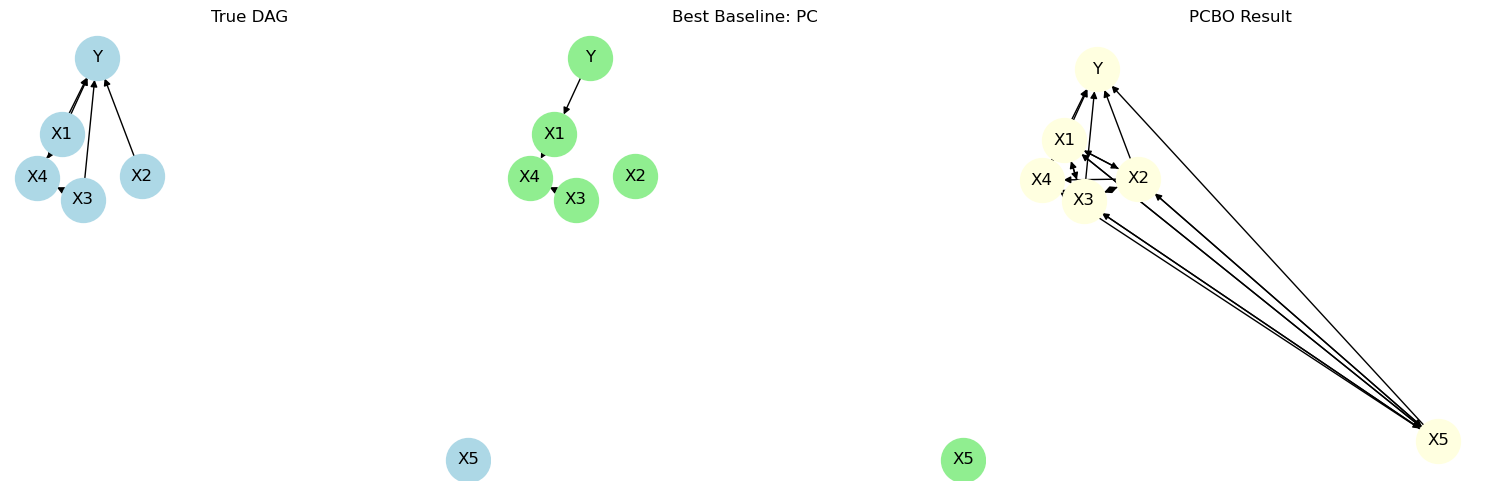


Note: These baselines use the intervention data but don't leverage
preference information, which is why PCBO should eventually outperform them
with proper tuning.


In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# True graph
ax = axes[0]
G_true = nx.DiGraph(true_adj.numpy())
pos = nx.spring_layout(G_true, seed=42)
nx.draw(G_true, pos, ax=ax, with_labels=True, 
        labels={i: node_names[i] for i in range(n_nodes)},
        node_color='lightblue', node_size=1000, font_size=12)
ax.set_title("True DAG")

# Best baseline
ax = axes[1]
G_baseline = nx.DiGraph(best_baseline[1]['adj'])
nx.draw(G_baseline, pos, ax=ax, with_labels=True,
        labels={i: node_names[i] for i in range(n_nodes)},
        node_color='lightgreen', node_size=1000, font_size=12)
ax.set_title(f"Best Baseline: {best_baseline[0]}")

# PCBO result (using final learned adjacency)
ax = axes[2]
learned_adj = torch.zeros_like(true_adj)
for lp in pcbo.local_posts.values():
    mask, _ = lp.most_probable_set()
    for k, is_parent in enumerate(mask):
        if is_parent:
            src = lp.parent_idx[k]
            learned_adj[src, lp.target_idx] = 1
G_pcbo = nx.DiGraph(learned_adj.numpy())
nx.draw(G_pcbo, pos, ax=ax, with_labels=True,
        labels={i: node_names[i] for i in range(n_nodes)},
        node_color='lightyellow', node_size=1000, font_size=12)
ax.set_title("PCBO Result")

plt.tight_layout()
plt.show()

print("\nNote: These baselines use the intervention data but don't leverage")
print("preference information, which is why PCBO should eventually outperform them")
print("with proper tuning.")

In [63]:
# niter = 50
# runs = {
#     "PCBO(default)": pcbo,  # your main run
#     "Random": run_baseline(dataset, niter, policy="random"),
#     "PIG-only": run_baseline(dataset, niter, policy="pig_only"),
#     "EEIG-only": run_baseline(dataset, niter, policy="eeig_only"),
#     "Two-stage(EEIG->PIG)": run_baseline(dataset, niter, policy="two_stage", Tc=20),
#     "Fixed alpha = 0.5": run_baseline(dataset, niter, policy="fixed_alpha", alpha_fixed=0.5),
# }

# # quick plots
# plt.figure(figsize=(13,4))
# plt.subplot(1,3,1); 
# for name, r in runs.items():
#     plt.plot(r.iteration_history, r.graph_distances, label=name)
# plt.title("SHD"); plt.xlabel("iter"); plt.ylabel("distance"); plt.legend()

# plt.subplot(1,3,2); 
# for name, r in runs.items():
#     plt.plot(r.iteration_history, r.edge_prob_errors, label=name)
# plt.title("Mean edge-prob error"); plt.xlabel("iter"); plt.ylim(0,1)

# plt.subplot(1,3,3); 
# for name, r in runs.items():
#     plt.plot(r.iteration_history, r.utility_errors, label=name)
# plt.title("Utility prediction error"); plt.xlabel("iter"); plt.ylim(0,1)
# plt.tight_layout()
# plt.show()

## Visualize Results

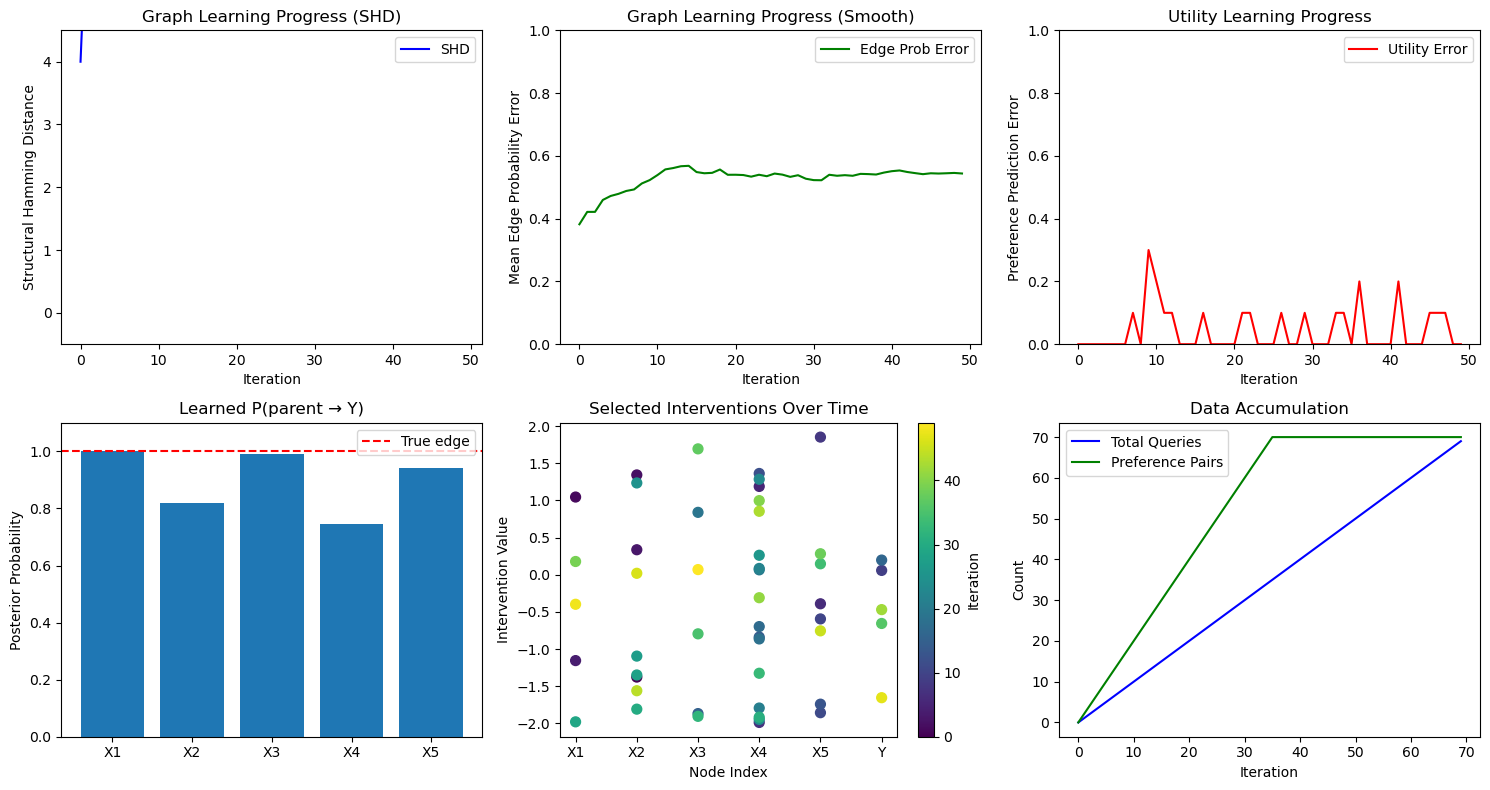

In [64]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 1. Graph Learning Progress (SHD)
axes[0, 0].plot(pcbo.iteration_history, pcbo.graph_distances, 'b-', label='SHD')
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Structural Hamming Distance")
axes[0, 0].set_title("Graph Learning Progress (SHD)")
axes[0, 0].set_ylim([-0.5, 4.5])
axes[0, 0].legend()

# 2. Edge Probability Error (Smoother metric)
axes[0, 1].plot(pcbo.iteration_history, pcbo.edge_prob_errors, 'g-', label='Edge Prob Error')
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("Mean Edge Probability Error")
axes[0, 1].set_title("Graph Learning Progress (Smooth)")
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()

# 3. Utility Learning Progress
axes[0, 2].plot(pcbo.iteration_history, pcbo.utility_errors, 'r-', label='Utility Error')
axes[0, 2].set_xlabel("Iteration")
axes[0, 2].set_ylabel("Preference Prediction Error")
axes[0, 2].set_title("Utility Learning Progress")
axes[0, 2].set_ylim([0, 1])
axes[0, 2].legend()

# 4. Final Edge Probabilities
edge_probs = pcbo.parent_posterior.edge_posterior().cpu().numpy()
pnames = [pcbo.node_names[i] for i in pcbo.parent_posterior.parent_idx]
axes[1, 0].bar(pnames, edge_probs)
axes[1, 0].axhline(y=1.0, color='r', linestyle='--', label='True edge')
axes[1, 0].set_ylabel("Posterior Probability")
axes[1, 0].set_title(f"Learned P(parent → {pcbo.node_names[pcbo.parent_posterior.target_idx]})")
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].legend()

# 5. Selected Interventions Over Time
if len(pcbo.selected_interventions) > 0:
    interventions_array = np.array(pcbo.selected_interventions)
    scatter = axes[1, 1].scatter(
        interventions_array[:, 0], interventions_array[:, 1],
        c=range(len(interventions_array)), cmap='viridis', s=50
    )
    plt.colorbar(scatter, ax=axes[1, 1], label='Iteration')
else:
    axes[1, 1].text(0.5, 0.5, "No interventions yet",
                    ha='center', va='center', transform=axes[1, 1].transAxes)
axes[1, 1].set_xlabel("Node Index")
axes[1, 1].set_ylabel("Intervention Value")
axes[1, 1].set_title("Selected Interventions Over Time")
axes[1, 1].set_xticks(list(range(len(pcbo.node_names))))
axes[1, 1].set_xticklabels(pcbo.node_names)

# 6. Preference Dataset Growth
axes[1, 2].plot(range(len(all_queries)), [i for i in range(len(all_queries))], 'b-', label='Total Queries')
axes[1, 2].plot(range(len(all_queries)), [min(i*2, len(pcbo.pref_dataset)) for i in range(len(all_queries))], 
               'g-', label='Preference Pairs')
axes[1, 2].set_xlabel("Iteration")
axes[1, 2].set_ylabel("Count")
axes[1, 2].set_title("Data Accumulation")
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## Final Results and Analysis


FINAL RESULTS

True causal graph:
[[0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

Most probable parent set for Y: (1, 1, 1, 1, 1)
Posterior probability: 0.568

Edge posterior probabilities:
  P(X1 → Y) = 1.000
  P(X2 → Y) = 0.821
  P(X3 → Y) = 0.990
  P(X4 → Y) = 0.745
  P(X5 → Y) = 0.940

Final metrics:
  SHD: 17.00
  Edge probability error: 0.544
  Utility prediction error: 0.000

Learning efficiency:
  Total queries: 70
  Total preference comparisons: 70
  Flow reinitializations: 0


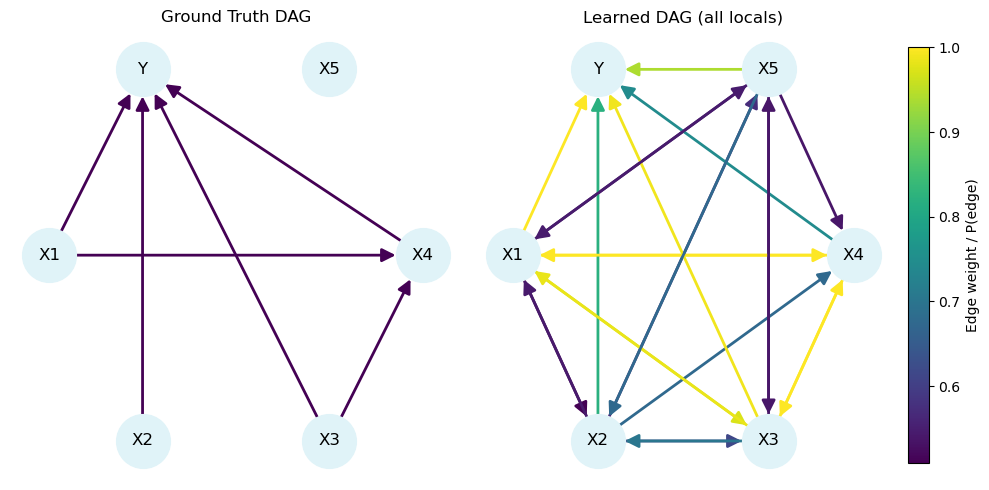


PCBO COMPLETE


In [65]:
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)

print(f"\nTrue causal graph:")
print(f"{true_adj.numpy()}")

most_prob_parents, prob = pcbo.parent_posterior.most_probable_set()
print(f"\nMost probable parent set for Y: {most_prob_parents}")
print(f"Posterior probability: {prob:.3f}")

edge_probs = pcbo.parent_posterior.edge_posterior()
print(f"\nEdge posterior probabilities:")
for j, pid in enumerate(pcbo.parent_posterior.parent_idx):
    print(f"  P({pcbo.node_names[pid]} → {pcbo.node_names[pcbo.parent_posterior.target_idx]}) = {edge_probs[j]:.3f}")

print(f"\nFinal metrics:")
print(f"  SHD: {pcbo.graph_distances[-1]:.2f}")
print(f"  Edge probability error: {pcbo.edge_prob_errors[-1]:.3f}")
print(f"  Utility prediction error: {pcbo.utility_errors[-1]:.3f}")

print(f"\nLearning efficiency:")
print(f"  Total queries: {len(all_queries)}")
print(f"  Total preference comparisons: {len(pcbo.pref_dataset)}")
print(f"  Flow reinitializations: {pcbo.reinitialization_count}")

# ---- Build learned graph & edge-prob matrix from all locals ----
learned_adj_full = torch.zeros_like(true_adj)
P_full = np.zeros_like(true_adj.cpu().numpy(), dtype=float)

for tgt, lp in pcbo.local_posts.items():
    # MAP edges for adjacency
    mask, _ = lp.most_probable_set()
    for j, is_parent in enumerate(mask):
        if is_parent:
            src = lp.parent_idx[j]
            learned_adj_full[src, lp.target_idx] = 1

    # Posterior edge probabilities into this target
    probs = lp.edge_posterior().cpu().numpy()
    for j, src in enumerate(lp.parent_idx):
        P_full[src, lp.target_idx] = float(probs[j])

# ---- Plot: ground truth vs learned (full) ----
fig, (axL, axR) = plt.subplots(1, 2, figsize=(10, 5))
plot_dag(true_adj.numpy(), names=node_names, edge_probs=(true_adj.numpy() > 0).astype(float), ax=axL)
axL.set_title("Ground Truth DAG")

plot_dag(learned_adj_full.numpy(), names=node_names, edge_probs=P_full, ax=axR)
axR.set_title("Learned DAG (all locals)")
plt.tight_layout(); plt.show()

print("\n" + "="*50)
print("PCBO COMPLETE")
print("="*50)


High-confidence edges (P >= 0.75):
  X1 → X3   (P = 0.972)
  X1 → X4   (P = 1.000)
  X1 → Y   (P = 1.000)
  X2 → Y   (P = 0.821)
  X3 → X1   (P = 0.984)
  X3 → X4   (P = 1.000)
  X3 → Y   (P = 0.990)
  X4 → X1   (P = 1.000)
  X4 → X3   (P = 1.000)
  X5 → Y   (P = 0.940)

High-confidence parents of Y (P >= 0.75):
  X1 → Y   (P = 1.000)
  X2 → Y   (P = 0.821)
  X3 → Y   (P = 0.990)
  X5 → Y   (P = 0.940)


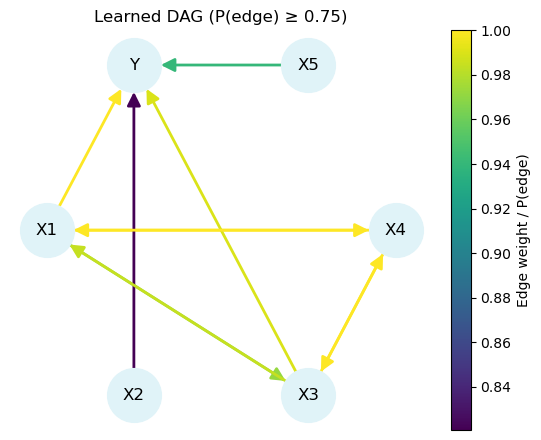

In [66]:
# === Show only high-confidence edges (P(edge) >= 0.9) ===
import numpy as np
import torch
import matplotlib.pyplot as plt

threshold = 0.75

# Use the edge-prob matrix we already built above (P_full)
P_thresh = P_full.copy()
adj_thresh = (P_thresh >= threshold).astype(int)

# No self-loops
np.fill_diagonal(adj_thresh, 0)

# Pretty print kept edges
kept = []
for i in range(adj_thresh.shape[0]):
    for j in range(adj_thresh.shape[1]):
        if adj_thresh[i, j] == 1:
            kept.append((pcbo.node_names[i], pcbo.node_names[j], P_thresh[i, j]))

print("\nHigh-confidence edges (P >= {:.2f}):".format(threshold))
if kept:
    for src, tgt, p in kept:
        print(f"  {src} → {tgt}   (P = {p:.3f})")
else:
    print("  (none)")

# Optional: also show high-confidence parents of Y specifically (if Y is in the graph)
if hasattr(pcbo, "parent_posterior"):
    y_idx = pcbo.parent_posterior.target_idx
    print("\nHigh-confidence parents of {} (P >= {:.2f}):".format(pcbo.node_names[y_idx], threshold))
    found = False
    for i in range(adj_thresh.shape[0]):
        if adj_thresh[i, y_idx] == 1:
            print(f"  {pcbo.node_names[i]} → {pcbo.node_names[y_idx]}   (P = {P_thresh[i, y_idx]:.3f})")
            found = True
    if not found:
        print("  (none)")

# Plot the pruned DAG; pass the original probabilities for edge coloring
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
plot_dag(torch.tensor(adj_thresh), names=pcbo.node_names, edge_probs=P_thresh, ax=ax)
ax.set_title(f"Learned DAG (P(edge) ≥ {threshold:.2f})")
plt.tight_layout()
plt.show()